# Point analysis for the PSA

Analysis of conventional stereotactic targets used in the posterior subthalamic area (PSA) for treating tremor.

In [1]:
# initialize libraries
library(plyr)
#library(dplyr)
library(digest)
library(reshape2)
library(ggplot2)
library(stringr) # for dataframe string parsing

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
# initialization of variables/setup is similar to XX_regions_of_interest.ipynb

# initialize variables
df_rois <- read.table('~/Documents/GitHub/zona-analysis/data/warped_seg_csv/combined_warp_seg_rois.csv', sep=",", header=TRUE)

tf <- ddply(df_rois, .(roi), summarize, t1map=mean(mean), t1map_sd=sd(mean))

# modify slightly so that ROIs categorized into GM,  WM, and "control" regions
cf <- data.frame(roi = tf$roi, class = c("GM","WM","WM","WM","WM","WM","WM","CTRL","GM","CTRL","GM"))
df_rois <- merge(df_rois,cf)

# order of presenting data (ZI, WM tracts of interest, control regions of interest)
roi_order <- c("cZI","rZI","ZI","fct","fl","ft","hf","hfields","ml","RN","STN")

names(df_rois)
head(df_rois)
str(df_rois)

[1] "roi"        "subjid"     "side"       "vol_voxels" "vol_mm"    
 [6] "centroid_x" "centroid_y" "centroid_z" "mean"       "sd"        
[11] "class"

roi,subjid,side,vol_voxels,vol_mm,centroid_x,centroid_y,centroid_z,mean,sd,class
cZI,sub-C001,L,282,97.21209,-13.384992,-3.959397,-25.53296,1243.869,88.96735,GM
cZI,sub-C002,L,271,93.42012,-10.155740,-15.776793,-45.84741,1212.469,76.40970,GM
cZI,sub-C003,L,255,87.90359,-6.721844,-19.315618,-22.90735,1276.349,94.77732,GM
cZI,sub-C004,L,263,90.66233,-12.538042,-12.146402,-37.80495,1274.460,89.50912,GM
cZI,sub-C005,L,238,82.04424,-10.024102,-13.336284,-20.69577,1310.693,86.84567,GM
cZI,sub-C006,L,204,70.32364,-9.889788,-7.443727,-18.75445,1275.147,87.62435,GM


'data.frame':	704 obs. of  11 variables:
 $ roi       : Factor w/ 11 levels "cZI","fct","fl",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ subjid    : Factor w/ 32 levels "sub-C001","sub-C002",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ side      : Factor w/ 2 levels "L","R": 1 1 1 1 1 1 1 1 1 1 ...
 $ vol_voxels: int  282 271 255 263 238 204 224 265 291 230 ...
 $ vol_mm    : num  97.2 93.4 87.9 90.7 82 ...
 $ centroid_x: num  -13.38 -10.16 -6.72 -12.54 -10.02 ...
 $ centroid_y: num  -3.96 -15.78 -19.32 -12.15 -13.34 ...
 $ centroid_z: num  -25.5 -45.8 -22.9 -37.8 -20.7 ...
 $ mean      : num  1244 1212 1276 1274 1311 ...
 $ sd        : num  89 76.4 94.8 89.5 86.8 ...
 $ class     : Factor w/ 3 levels "CTRL","GM","WM": 2 2 2 2 2 2 2 2 2 2 ...


In [3]:
# manipulations to make sure ordered in roi_order way for readability
df_rois$roi <- factor(df_rois$roi, levels = roi_order)
rowidx <- order(df_rois[,"roi"])

In [4]:
# summarize metrics (note: centroid calculations excluded for now)
summary_all_roi_metrics <- ddply(df_rois, .(roi,side), summarize, vol_voxels_mean=mean(vol_voxels), vol_voxels_sd=sd(vol_voxels), vol_mm_mean=mean(vol_mm), vol_mm_sd=sd(vol_mm), t1map=mean(mean), t1map_sd=sd(mean))

In [5]:
#ddply(df_rois, .(roi), summarize, vol_voxels_mean=mean(vol_voxels), vol_voxels_sd=sd(vol_voxels), vol_mm_mean=mean(vol_mm), vol_mm_sd=sd(vol_mm), t1map=mean(mean), t1map_sd=sd(mean))

In [6]:
unique(df_rois$roi)

[1] cZI     fct     fl      ft      hf      hfields ml      RN      rZI    
[10] STN     ZI     
Levels: cZI rZI ZI fct fl ft hf hfields ml RN STN

## Coordinates

Compute the coordinates for each CoM based on the midcommissural point.

In [7]:
# initialize variables and load in all the afids data then calculate the MCP
setwd('~/Documents/GitHub/zona-analysis/data/input_afid_subjects_postQC/')

df_afid <- read.table('~/Documents/GitHub/zona-analysis/etc/afids.csv', sep=",", header=TRUE)

df_subjects <- data.frame(fid=integer(),X=double(),Y=double(),Z=double(),
                        subjid=factor(), name=character(),description=character(),stringsAsFactors = FALSE)

csv_files <- list.files(".", "*.fcsv")

for (i in 1:length(csv_files)) {
        curr_split <- unlist(strsplit(csv_files[i],"_"))
        
        curr_subject <- read.table(csv_files[i], header=FALSE, sep=",")
        df_subject <- data.frame(fid = 1:length(curr_subject$V1))
        
        df_subject <- cbind(df_subject,X=curr_subject[2],Y=curr_subject[3],Z=curr_subject[4],
                          subjid=as.factor(curr_split[1]), name=curr_subject[12], description=curr_subject[13])
        
        df_subject <- plyr::rename(df_subject, c("V2"="X","V3"="Y","V4"="Z","V12"="name","V13"="description"))
        df_subjects <- rbind(df_subjects,df_subject)
}

df_AC <- subset(df_subjects, fid == 1)
df_PC <- subset(df_subjects, fid == 2)

df_ACPC <- merge(df_AC, df_PC, by=c("subjid"))
df_ACPC <- plyr::rename(df_ACPC, c("X.x"="AC_X","Y.x"="AC_Y","Z.x"="AC_Z",
                                   "X.y"="PC_X","Y.y"="PC_Y","Z.y"="PC_Z"))
df_ACPC <- subset(df_ACPC, select = c(subjid, AC_X, AC_Y, AC_Z, PC_X, PC_Y, PC_Z))
df_ACPC$MCP_X <- (df_ACPC$AC_X + df_ACPC$PC_X) / 2.0
df_ACPC$MCP_Y <- (df_ACPC$AC_Y + df_ACPC$PC_Y) / 2.0
df_ACPC$MCP_Z <- (df_ACPC$AC_Z + df_ACPC$PC_Z) / 2.0
#df_ACPC


In [8]:
# calculate the centroids for each structure after normalization
df_rois_with_MCP <- df_rois
#df_rois_with_MCP$MCP_centroid_x <- df_rois_with_MCP$centroid_x - subset(df_ACPC, )

dfm <- data.frame(  MCP_centroid_x = 1:length(df_rois_with_MCP$roi),
                    MCP_centroid_y = 1:length(df_rois_with_MCP$roi),
                    MCP_centroid_z = 1:length(df_rois_with_MCP$roi))

for (i in 1:length(df_rois_with_MCP$roi)) {
        
        dfm$MCP_centroid_x[i] <- df_rois_with_MCP$centroid_x[i] - subset(df_ACPC, subjid == df_rois_with_MCP$subjid[i] )$MCP_X
        dfm$MCP_centroid_y[i] <- df_rois_with_MCP$centroid_y[i] - subset(df_ACPC, subjid == df_rois_with_MCP$subjid[i] )$MCP_Y
        dfm$MCP_centroid_z[i] <- df_rois_with_MCP$centroid_z[i] - subset(df_ACPC, subjid == df_rois_with_MCP$subjid[i] )$MCP_Z

}

df_rois_with_MCP <- cbind(df_rois_with_MCP,dfm)
head(df_rois_with_MCP)


roi,subjid,side,vol_voxels,vol_mm,centroid_x,centroid_y,centroid_z,mean,sd,class,MCP_centroid_x,MCP_centroid_y,MCP_centroid_z
cZI,sub-C001,L,282,97.21209,-13.384992,-3.959397,-25.53296,1243.869,88.96735,GM,-13.59080,-8.802065,-5.060911
cZI,sub-C002,L,271,93.42012,-10.155740,-15.776793,-45.84741,1212.469,76.40970,GM,-12.03212,-6.348238,-6.164611
cZI,sub-C003,L,255,87.90359,-6.721844,-19.315618,-22.90735,1276.349,94.77732,GM,-12.04729,-9.365631,-5.277319
cZI,sub-C004,L,263,90.66233,-12.538042,-12.146402,-37.80495,1274.460,89.50912,GM,-12.99700,-8.823180,-5.620163
cZI,sub-C005,L,238,82.04424,-10.024102,-13.336284,-20.69577,1310.693,86.84567,GM,-13.42312,-7.569002,-4.392932
cZI,sub-C006,L,204,70.32364,-9.889788,-7.443727,-18.75445,1275.147,87.62435,GM,-11.20304,-8.275177,-3.220854


## Propagated PSA points

Load in the coordinates for the propagated posterior subthalamic area (PSA) points (Blomstedt2010 and Nowacki2018) and integrated into `df_rois_with_MCP` dataframe.

In [9]:
# setup variables and load

# useful functions

# calculate the distance between two sets of coordinates
dist3D <- function(coord1, coord2) { # vector X,Y,Z
        xdist <- coord1[1] - coord2[1] # could also write as coord1$X, etc.
        ydist <- coord1[2] - coord2[2]
        zdist <- coord1[3] - coord2[3]
        euclidean_dist <- sqrt(xdist^2+ydist^2+zdist^2)
        return(as.numeric(unlist(euclidean_dist)))
}

# calculate the pairwise distance between an array of 3D coordinates
pairwise_dist3D <- function(temp_coords) { # labeled X,Y,Z
        N <- length(temp_coords$X)
        dist_vec <- rep(0,N) # create vector
        sum_dist <- 0 # initialize to zero
        count <- 0
        for (i in 1:(N-1)) {
                for (j in (i+1):N) {
                        if (i != j) {
                                count <- count + 1
                                first_coord <- temp_coords[i,]
                                second_coord <- temp_coords[j,]
                                curr_dist <- dist3D(first_coord, second_coord)
                                sum_dist <- sum_dist + curr_dist
                                dist_vec[count] <- curr_dist
                        }
                }
        }
        return(c(as.numeric(unlist(mean(dist_vec))),as.numeric(unlist(sd(dist_vec)))))
}


df_psa <- read.table('~/Documents/GitHub/zona-analysis/data/psa_points//output_data//psa_points.csv', sep=",", header=TRUE)

# prepare data
parse_target_desc <- str_split_fixed(df_psa$target_desc, "_", 3)
#df_psa$side <- parse_target_desc[1]
df_psa$side <- as.factor(parse_target_desc[,1])
df_psa$target <- as.factor(parse_target_desc[,2])

#head(df_psa)
#head(df_rois_with_MCP)

# merge MCP data with PSA data to allow distance calculations
df_rois_with_MCP_and_PSA <- merge(df_rois_with_MCP,df_psa,by=c("subjid","side"))

df_rois_with_MCP_and_PSA$dist <- dist3D(df_rois_with_MCP_and_PSA[,6:8],df_rois_with_MCP_and_PSA[,15:17])

head(df_rois_with_MCP_and_PSA)



subjid,side,roi,vol_voxels,vol_mm,centroid_x,centroid_y,centroid_z,mean,sd,class,MCP_centroid_x,MCP_centroid_y,MCP_centroid_z,x,y,z,target_desc,target,dist
sub-C001,L,cZI,282,97.21209,-13.384992,-3.959397,-25.53296,1243.869,88.96735,GM,-13.590797,-8.8020653,-5.060911,-10.7898,-1.978910,-26.2991,L_Target01_Consensus,Target01,3.353255
sub-C001,L,cZI,282,97.21209,-13.384992,-3.959397,-25.53296,1243.869,88.96735,GM,-13.590797,-8.8020653,-5.060911,-9.8590,-0.558569,-25.6075,L_Target02_Consensus,Target02,4.899368
sub-C001,L,hf,167,57.56886,-5.145751,4.555637,-22.22689,1120.695,83.58746,WM,-5.351556,-0.2870313,-1.754839,-10.7898,-1.978910,-26.2991,L_Target01_Consensus,Target01,9.546648
sub-C001,L,hf,167,57.56886,-5.145751,4.555637,-22.22689,1120.695,83.58746,WM,-5.351556,-0.2870313,-1.754839,-9.8590,-0.558569,-25.6075,L_Target02_Consensus,Target02,7.732939
sub-C001,L,rZI,525,180.97995,-7.207888,6.269111,-22.14502,1209.038,129.85589,GM,-7.413693,1.4264427,-1.672965,-10.7898,-1.978910,-26.2991,L_Target01_Consensus,Target01,9.905371
sub-C001,L,rZI,525,180.97995,-7.207888,6.269111,-22.14502,1209.038,129.85589,GM,-7.413693,1.4264427,-1.672965,-9.8590,-0.558569,-25.6075,L_Target02_Consensus,Target02,8.101507


## Summary and statistics for point distance

Results demonstrate statistically significant difference in the distance between the centroid of fct and cZI and Targets 01 and 02.

pdf 
  2

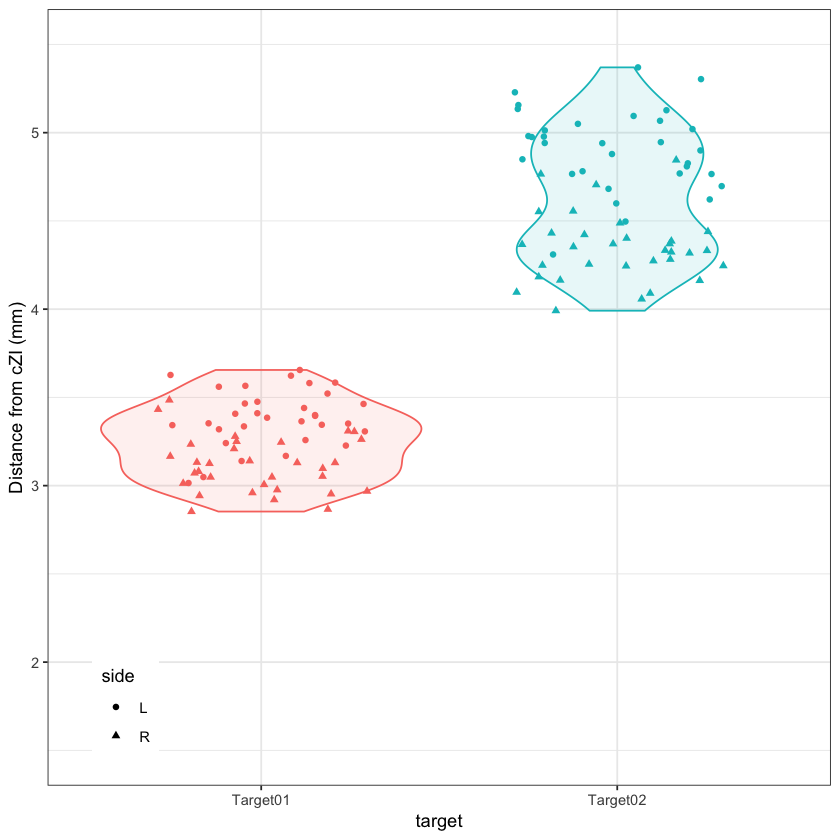

pdf 
  2

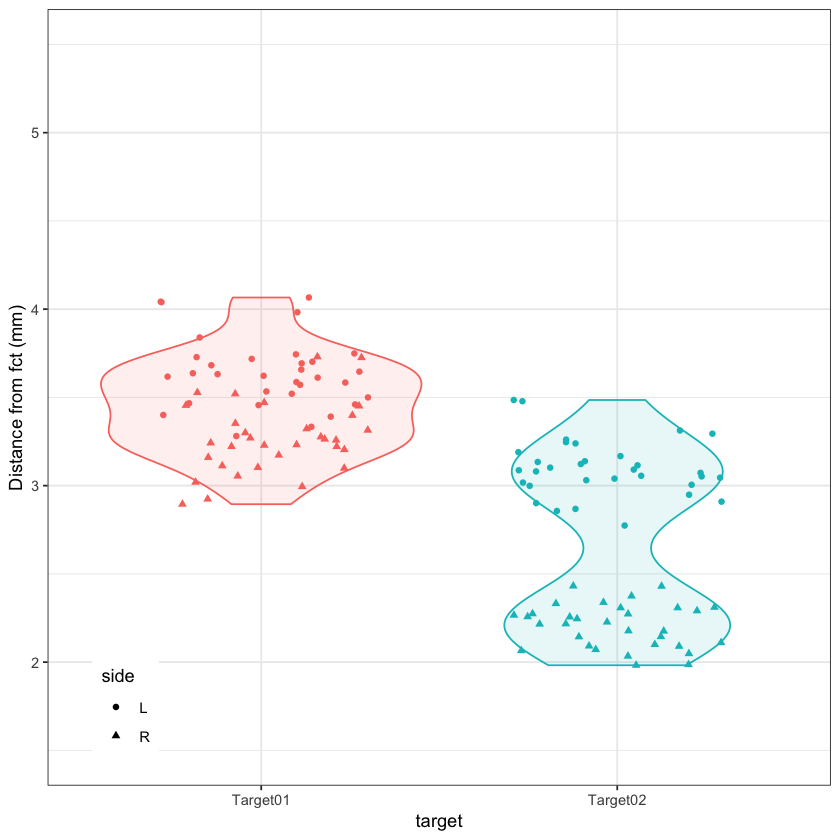

In [10]:
#df_plot_cZI <- subset(df_rois_with_MCP_and_PSA, roi==c("cZI"))
df_plot_cZI <- subset(df_rois_with_MCP_and_PSA, roi==c("cZI"))

g <- ggplot(data = df_plot_cZI, aes(x = target, y = dist)) + geom_violin(alpha = 0.1, aes(color=target,fill=target)) +
    geom_jitter(aes(color=target,shape=side),width=0.3) +
#    geom_jitter()+
#    scale_x_discrete(name="Targets",limits=roi_order) +
    scale_y_continuous(name="Distance from cZI (mm)",limits=c(1.5,5.5)) +
    theme_bw() + guides(size = "legend", colour = "none", fill = "none") +
    theme(legend.position=c(0.1, 0.1))
g

pdf(file = "~/Documents/GitHub/zona-analysis/figures/supp_fig_dist_cZI.pdf", width = 4, height = 5)
g
dev.off()

df_plot_fct <- subset(df_rois_with_MCP_and_PSA, roi==c("fct"))

g <- ggplot(data = df_plot_fct, aes(x = target, y = dist)) + geom_violin(alpha = 0.1, aes(color=target,fill=target)) +
    geom_jitter(aes(color=target,shape=side),width=0.3) +
#    geom_jitter()+
#    scale_x_discrete(name="Targets",limits=roi_order) +
    scale_y_continuous(name="Distance from fct (mm)",limits=c(1.5,5.5)) +
    theme_bw() + guides(size = "legend", colour = "none", fill = "none") +
    theme(legend.position=c(0.1, 0.1))
g

pdf(file = "~/Documents/GitHub/zona-analysis/figures/supp_fig_dist_fct.pdf", width = 4, height = 5)
g
dev.off()


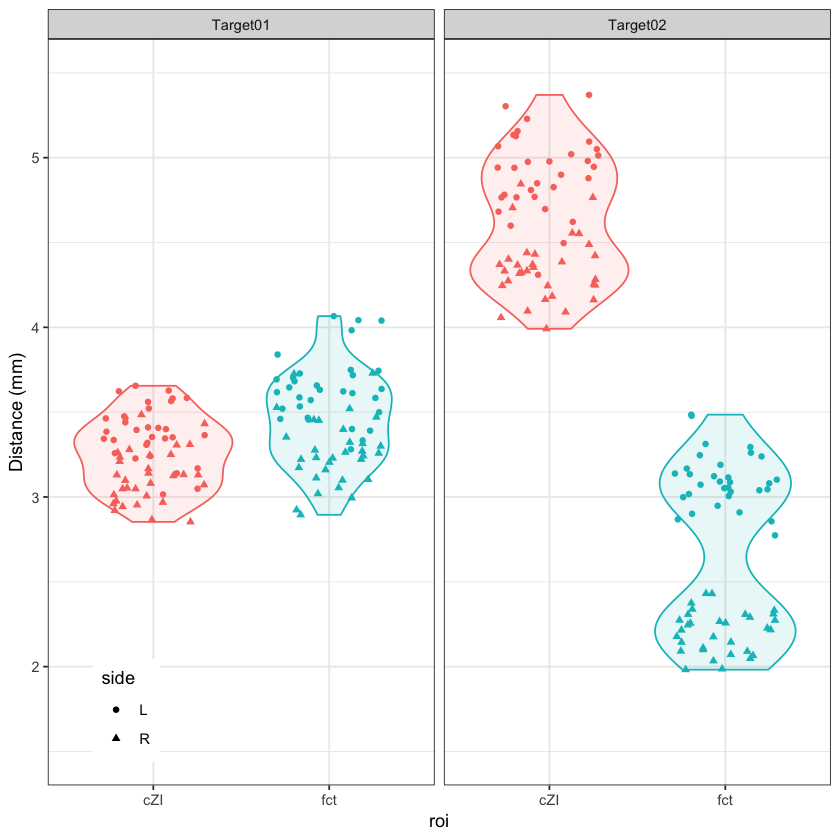

In [11]:
# plot of the distance between targets and relevant nearby structures
df_plot_PSA <- subset(df_rois_with_MCP_and_PSA, roi==c("cZI") | roi==c("fct"))

g <- ggplot(data = df_plot_PSA, aes(x = roi, y = dist)) + geom_violin(alpha = 0.1, aes(color=roi,fill=roi)) +
    geom_jitter(aes(color=roi,shape=side),width=0.3) +
#    geom_jitter()+
#    scale_x_discrete(name="Targets",limits=roi_order) +
    scale_y_continuous(name="Distance (mm)",limits=c(1.5,5.5)) +
    theme_bw() + guides(size = "legend", colour = "none", fill = "none") +
    theme(legend.position=c(0.1, 0.1))
g+facet_wrap(~ target)


In [12]:
# summary and statistics

ddply(subset(df_rois_with_MCP_and_PSA, roi==c("fct","cZI")),
      .(roi,target), summarize, mean_dist=mean(dist), sd_dist=sd(dist))

ddply(subset(df_rois_with_MCP_and_PSA, roi==c("fct","cZI")),
      .(roi,target,side), summarize, mean_dist=mean(dist), sd_dist=sd(dist))

wilcox.test(x = subset(df_rois_with_MCP_and_PSA,target=="Target01" & side=="L" & roi=="fct")$dist,
            y = subset(df_rois_with_MCP_and_PSA,target=="Target02" & side=="L" & roi=="fct")$dist)
wilcox.test(x = subset(df_rois_with_MCP_and_PSA,target=="Target01" & side=="L" & roi=="cZI")$dist,
            y = subset(df_rois_with_MCP_and_PSA,target=="Target02" & side=="L" & roi=="cZI")$dist)
wilcox.test(x = subset(df_rois_with_MCP_and_PSA,target=="Target01" & side=="R" & roi=="fct")$dist,
            y = subset(df_rois_with_MCP_and_PSA,target=="Target02" & side=="R" & roi=="fct")$dist)
wilcox.test(x = subset(df_rois_with_MCP_and_PSA,target=="Target01" & side=="R" & roi=="cZI")$dist,
            y = subset(df_rois_with_MCP_and_PSA,target=="Target02" & side=="R" & roi=="cZI")$dist)

wilcox.test(x = subset(df_rois_with_MCP_and_PSA,target=="Target01" & roi=="cZI")$dist,
            y = subset(df_rois_with_MCP_and_PSA,target=="Target02" & roi=="cZI")$dist)
wilcox.test(x = subset(df_rois_with_MCP_and_PSA,target=="Target01" & roi=="fct")$dist,
            y = subset(df_rois_with_MCP_and_PSA,target=="Target02" & roi=="fct")$dist)




roi,target,mean_dist,sd_dist
cZI,Target01,3.304966,0.2162667
cZI,Target02,4.620806,0.3572140
fct,Target01,3.455215,0.2729396
fct,Target02,2.635237,0.5231951


roi,target,side,mean_dist,sd_dist
cZI,Target01,L,3.434858,0.08955411
cZI,Target01,R,3.175075,0.24143963
cZI,Target02,L,4.905212,0.23948734
cZI,Target02,R,4.336399,0.18669578
fct,Target01,L,3.635613,0.20514762
fct,Target01,R,3.274817,0.20531869
fct,Target02,L,3.109451,0.01646842
fct,Target02,R,2.161022,0.09707845



	Wilcoxon rank sum test

data:  subset(df_rois_with_MCP_and_PSA, target == "Target01" & side ==  and subset(df_rois_with_MCP_and_PSA, target == "Target02" & side ==     "L" & roi == "fct")$dist and     "L" & roi == "fct")$dist
W = 1008, p-value = 9.986e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test

data:  subset(df_rois_with_MCP_and_PSA, target == "Target01" & side ==  and subset(df_rois_with_MCP_and_PSA, target == "Target02" & side ==     "L" & roi == "cZI")$dist and     "L" & roi == "cZI")$dist
W = 0, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test

data:  subset(df_rois_with_MCP_and_PSA, target == "Target01" & side ==  and subset(df_rois_with_MCP_and_PSA, target == "Target02" & side ==     "R" & roi == "fct")$dist and     "R" & roi == "fct")$dist
W = 1024, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test

data:  subset(df_rois_with_MCP_and_PSA, target == "Target01" & side ==  and subset(df_rois_with_MCP_and_PSA, target == "Target02" & side ==     "R" & roi == "cZI")$dist and     "R" & roi == "cZI")$dist
W = 0, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(df_rois_with_MCP_and_PSA, target == "Target01" & roi ==  and subset(df_rois_with_MCP_and_PSA, target == "Target02" & roi ==     "cZI")$dist and     "cZI")$dist
W = 0, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(df_rois_with_MCP_and_PSA, target == "Target01" & roi ==  and subset(df_rois_with_MCP_and_PSA, target == "Target02" & roi ==     "fct")$dist and     "fct")$dist
W = 3824, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


## T1 map values

Determine if there is any link between local T1 values at the indirect targets and tissue type

In [13]:
# load in local T1 map values
df_psa_T1_orig <- read.table('~/Documents/GitHub/zona-analysis/data/psa_points//psa_points_T1vals.csv', sep=",", header=TRUE)

# reformat the data
tmp_df_LT01 <- df_psa_T1_orig[,c(1,2)]
tmp_df_LT01$target <- "Target01"
tmp_df_LT01$side <- "L"
names(tmp_df_LT01)[2] <- "T1"

tmp_df_RT01 <- df_psa_T1_orig[,c(1,3)]
tmp_df_RT01$target <- "Target01"
tmp_df_RT01$side <- "R"
names(tmp_df_RT01)[2] <- "T1"

tmp_df_LT02 <- df_psa_T1_orig[,c(1,4)]
tmp_df_LT02$target <- "Target02"
tmp_df_LT02$side <- "L"
names(tmp_df_LT02)[2] <- "T1"

tmp_df_RT02 <- df_psa_T1_orig[,c(1,5)]
tmp_df_RT02$target <- "Target02"
tmp_df_RT02$side <- "R"
names(tmp_df_RT02)[2] <- "T1"

df_psa_T1 <- rbind(tmp_df_LT01, tmp_df_RT01)
df_psa_T1 <- rbind(df_psa_T1, tmp_df_LT02)
df_psa_T1 <- rbind(df_psa_T1, tmp_df_RT02)

length(df_psa_T1$target) # 32 subjects x 2 sides x 2 targets = 128

ddply(df_psa_T1, .(target), summarize, mean_T1=mean(T1), sd_T1=sd(T1))
ddply(df_psa_T1, .(target,side), summarize, mean_T1=mean(T1), sd_T1=sd(T1))

wilcox.test(x = subset(df_psa_T1,target=="Target01")$T1, y = subset(df_psa_T1,target=="Target02")$T1)

[1] 128

target,mean_T1,sd_T1
Target01,1250.157,70.40093
Target02,1221.868,59.35717


target,side,mean_T1,sd_T1
Target01,L,1285.671,57.11779
Target01,R,1214.641,64.85379
Target02,L,1256.794,45.91216
Target02,R,1186.942,50.33802



	Wilcoxon rank sum test with continuity correction

data:  subset(df_psa_T1, target == "Target01")$T1 and subset(df_psa_T1, target == "Target02")$T1
W = 2535, p-value = 0.02042
alternative hypothesis: true location shift is not equal to 0


pdf 
  2

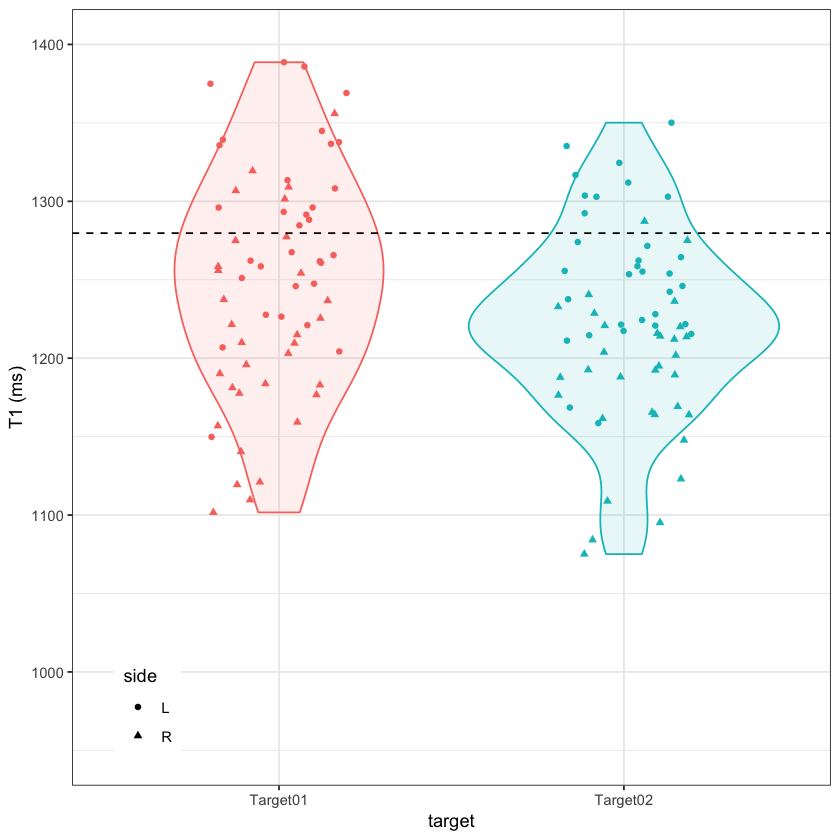

In [14]:
g <- ggplot(data = df_psa_T1, aes(target,T1)) + geom_violin(alpha = 0.1, aes(color=target,fill=target)) +
    geom_jitter(aes(color=target,shape=side),width=0.2) +
#    scale_x_discrete(name="Targets",limits=roi_order) +
#    scale_color_brewer(palette = "Accent") +
# mean cZI value is 1279.7 ms
    geom_hline(yintercept = 1279.7, linetype="dashed") +
    scale_y_continuous(name="T1 (ms)",limits=c(950,1400)) +
    theme_bw() + guides(size = "legend", colour = "none", fill = "none") +
    theme(legend.position=c(0.1, 0.1))
g

pdf(file = "~/Documents/GitHub/zona-analysis/figures/supp_fig_T1_targets.pdf", width = 4, height = 5)
g
dev.off()

In [15]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.2

Matrix products: default
BLAS/LAPACK: /Users/jclau/anaconda3/envs/r-tutorial/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] stringr_1.4.0  ggplot2_3.1.1  reshape2_1.4.3 digest_0.6.18  plyr_1.8.4    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       magrittr_1.5     tidyselect_0.2.5 munsell_0.5.0   
 [5] uuid_0.1-2       colorspace_1.4-1 R6_2.4.0         rlang_0.3.4     
 [9] dplyr_0.8.0.1    tools_3.6.1      grid_3.6.1       gtable_0.3.0    
[13] withr_2.1.2      htmltools_0.3.6  assertthat_0.2.1 lazyeval_0.2.2  
[17] tibble_2.1.1     crayon_1.3.4     IRdisplay_0.7.0  purrr_0.3.2     
[21] repr_0.19.2      base64enc_0.1-3  IRkernel_0.8.15  glue_1.3.1      
[25] evaluate_0.13    la